# GSEA analysis

## IS-GSEA

In [1]:
library('fgsea')
library('msigdbr')
library('ggplot2')

In [2]:
paths <- list( 'KO-Y'='subdata/IS_results_KO::young.csv', 
               'WT-Y'='subdata/IS_results_WT::young.csv', 
               'old-Y'='subdata/IS_results_old::young.csv',
               'KO-WT'='subdata/IS_results_KO::WT.csv',
               'old-WT'='subdata/IS_results_old::WT.csv',
               'DE:old-Y'='subdata/DE_results_old::young.csv')

In [24]:
species = 'mouse'
type = 'Symbol'

#fetch gene sets
m_df_h = msigdbr(species = species, category = "H")
# m_df_bp = msigdbr(species = species, category = "C5",subcategory = "BP")
# m_df_kegg = msigdbr(species = species, category = "C2",subcategory = "CP:KEGG")
# m_df_reactome = msigdbr(species = species, category = "C2",subcategory = "CP:REACTOME")
m_df <- m_df_h#rbind(rbind(m_df_h, m_df_bp,m_df_kegg),m_df_reactome)
#prepare gene sets
functions_list <- levels(factor(m_df$gs_name))
functions_annotation <- list()
for (i in functions_list){
    temp_data <- m_df[m_df$gs_name==i,]
    if (type=="Symbol"){
        temp_data <- toupper(as.character(temp_data$gene_symbol))
    }else if (type=="Entrez"){
        temp_data <- as.character(temp_data$entrez_gene)      
    }
    functions_annotation[[i]] <- temp_data
}

ds <- list()
fres <- list()
for (path in names(paths)){
    IS <- read.csv(paths[[path]])
    ranked_list <- IS[c('Name', 'ES')]
    ranked_list <- ranked_list[order(ranked_list[,2],decreasing = T),]
    ranked_vector <- ranked_list[,2]
    names(ranked_vector) <- toupper(as.character(ranked_list[,1]))
    
    res <- fgsea(pathways = functions_annotation, 
                stats    = ranked_vector,
                nperm = 10000,
                minSize  = 10,
                maxSize  = 500)
    fres[[path]] <- res
    ds[[path]] <- IS
}


Warning message in fgsea(pathways = functions_annotation, stats = ranked_vector, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.9% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = functions_annotation, stats = ranked_vector, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.9% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in

NES

Using rowname as id variables

Using rowname as id variables



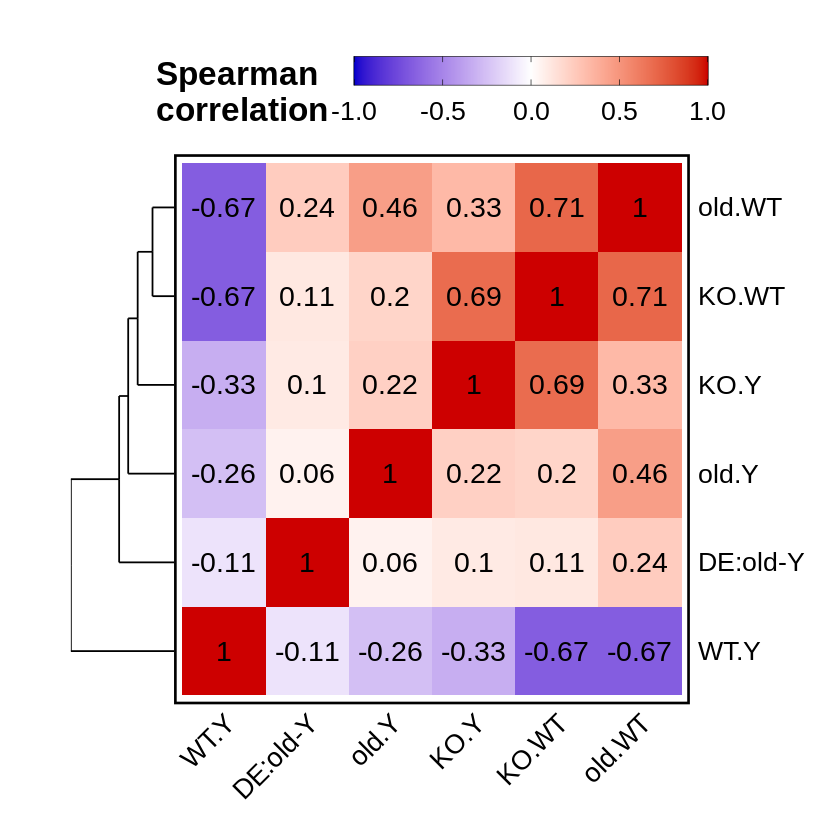

In [25]:
nesdf <- data.frame(row.names=fres[['KO-Y']]$pathway)
pdf <- data.frame(row.names=fres[['KO-Y']]$pathway)
disdf <- data.frame(row.names=ds[['KO-Y']]$Name)
for (n in names(fres)){
    #disdf[n] <- ds[[n]]$FC
    nesdf <- transform(merge(nesdf, fres[[n]][,c('pathway','NES')], by.x='row.names', by.y='pathway'),
                       row.names=Row.names, Row.names=NULL)
    colnames(nesdf)[colnames(nesdf) == "NES"] <- n
    
    pdf <- transform(merge(pdf, fres[[n]][,c('pathway','pval')], by.x='row.names', by.y='pathway'),
                       row.names=Row.names, Row.names=NULL)
    colnames(pdf)[colnames(pdf) == "pval"] <- n

    #pdf[n] <- fres[[n]]$pval 
}

cat('NES')
source('utils/ggcorplot.R')
options(repr.plot.width = 7, repr.plot.height = 7)
p <- ggheatmap(nesdf, method='spearman')
cowplot::plot_grid(p)

# cat('diff-IS')
# source('utils/ggcorplot.R')
# options(repr.plot.width = 7, repr.plot.height = 7)
# p <- ggheatmap(disdf)
# cowplot::plot_grid(p)

Using rowname as id variables

Using rowname as id variables

Warning message:
“Removed 16 rows containing missing values (geom_text).”


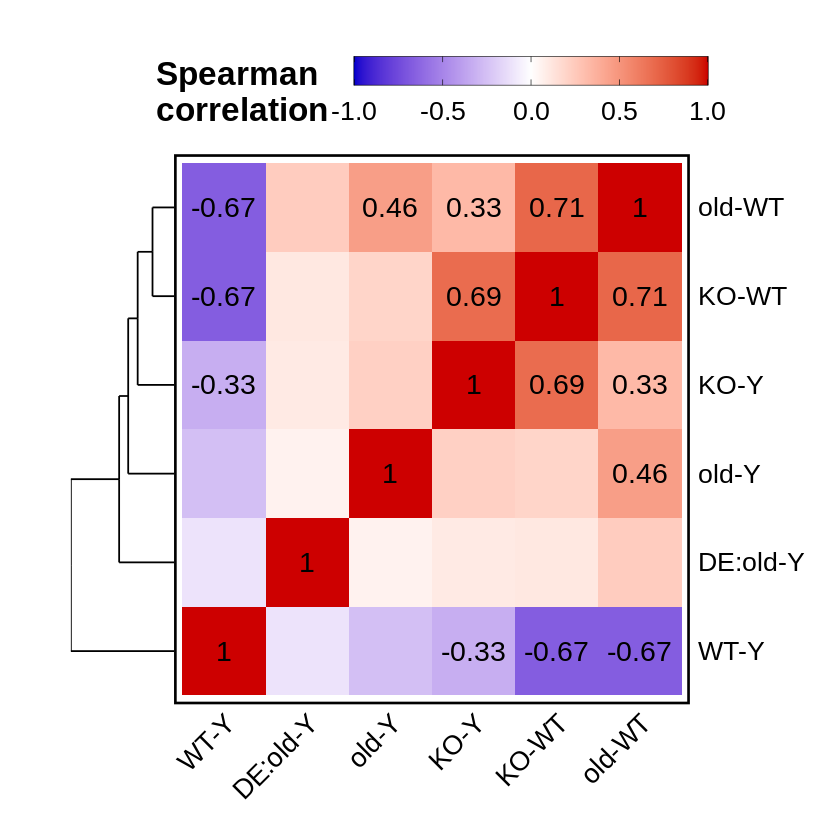

In [59]:
for (name in names(fres)){
    fres[[name]] <- as.data.frame(fres[[name]])
    rownames(fres[[name]]) <- fres[[name]]$pathway
}

source('utils/ggcorplot.R')
options(repr.plot.width = 7, repr.plot.height = 7)
p <- ggheatmap(fres, type='pairwise_top', 
                method='spearman', top=50,
                measure="NES", criterion="padj", criterion_thr=0.1)
cowplot::plot_grid(p)

[1] "HALLMARK_MYOGENESIS"                     
 [2] "HALLMARK_MTORC1_SIGNALING"               
 [3] "HALLMARK_MYC_TARGETS_V1"                 
 [4] "HALLMARK_MITOTIC_SPINDLE"                
 [5] "HALLMARK_MYC_TARGETS_V2"                 
 [6] "HALLMARK_ADIPOGENESIS"                   
 [7] "HALLMARK_OXIDATIVE_PHOSPHORYLATION"      
 [8] "HALLMARK_P53_PATHWAY"                    
 [9] "HALLMARK_E2F_TARGETS"                    
[10] "HALLMARK_DNA_REPAIR"                     
[11] "HALLMARK_G2M_CHECKPOINT"                 
[12] "HALLMARK_UNFOLDED_PROTEIN_RESPONSE"      
[13] "HALLMARK_APICAL_JUNCTION"                
[14] "HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY"
[15] "HALLMARK_FATTY_ACID_METABOLISM"

In [45]:
# nm1 <- rownames(pdf[order(pdf[['KO.Y']]),][1:5,])
# nm2 <- rownames(pdf[order(pdf[['old.Y']]),][1:5,])
# nm3 <- rownames(pdf[order(pdf[['WT.Y']]),][1:5,])

# nm <- unique(c(nm1, nm2, nm3))

#gmean
gmean <- function(x) exp(mean(log(x)))
gm <- as.data.frame(list("gmean"=apply(pdf, 1, gmean)))
nm <- rownames(gm[order(gm$gmean),, FALSE])[1:15]

# nm <- rownames(nesdf[sign(nesdf$old) != sign(nesdf$WT),])
# print(length(nm))
# tmp <- pdf[nm,]
# nm <- rownames(tmp[order(tmp$WT),][1:20,])

In [46]:
melt <- data.frame()
for (n in names(fres)){
    fres[[n]]$type <- n
    melt <- rbind(melt, fres[[n]])
}

In [47]:
#submelt <- melt[grepl('HALLMARK', melt$pathway),]
submelt <- melt[melt$pathway %in% nm,]

In [57]:
pdf[nm,]

,KO.Y,WT.Y,old.Y,KO.WT,old.WT,DE:old-Y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HALLMARK_MYOGENESIS,0.0040522743,0.0023106817,0.0142137097,0.0003014167,0.0001001904,0.5226601841
HALLMARK_MTORC1_SIGNALING,0.0005060217,0.0063051702,0.0569499042,0.0003013864,0.0001001803,0.9296100463
HALLMARK_MYC_TARGETS_V1,0.0208924949,0.0068500369,0.0134180791,0.0005027652,0.0220440882,0.0218169977
HALLMARK_MITOTIC_SPINDLE,0.3114372470,0.0004201239,0.0286146096,0.0595560912,0.0017028949,0.0023529412
HALLMARK_MYC_TARGETS_V2,0.0039599604,0.0008244994,0.4104686156,0.0001067008,0.0392258870,0.4682059740
HALLMARK_ADIPOGENESIS,0.1679134654,0.0024040974,0.1044791142,0.0004013646,0.0015018022,0.6097560976
HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.0046634225,0.0210681555,0.1327620968,0.0012059090,0.0944795111,0.0139607032
HALLMARK_P53_PATHWAY,0.0019252204,0.0969639668,0.1029441420,0.0035158212,0.0008016032,0.6882012921
HALLMARK_E2F_TARGETS,0.2769230769,0.2003991177,0.0451385390,0.0661845938,0.0125212862,0.0001695490


In [52]:
submelt$pathway <- factor(submelt$pathway, levels=rev(nm))

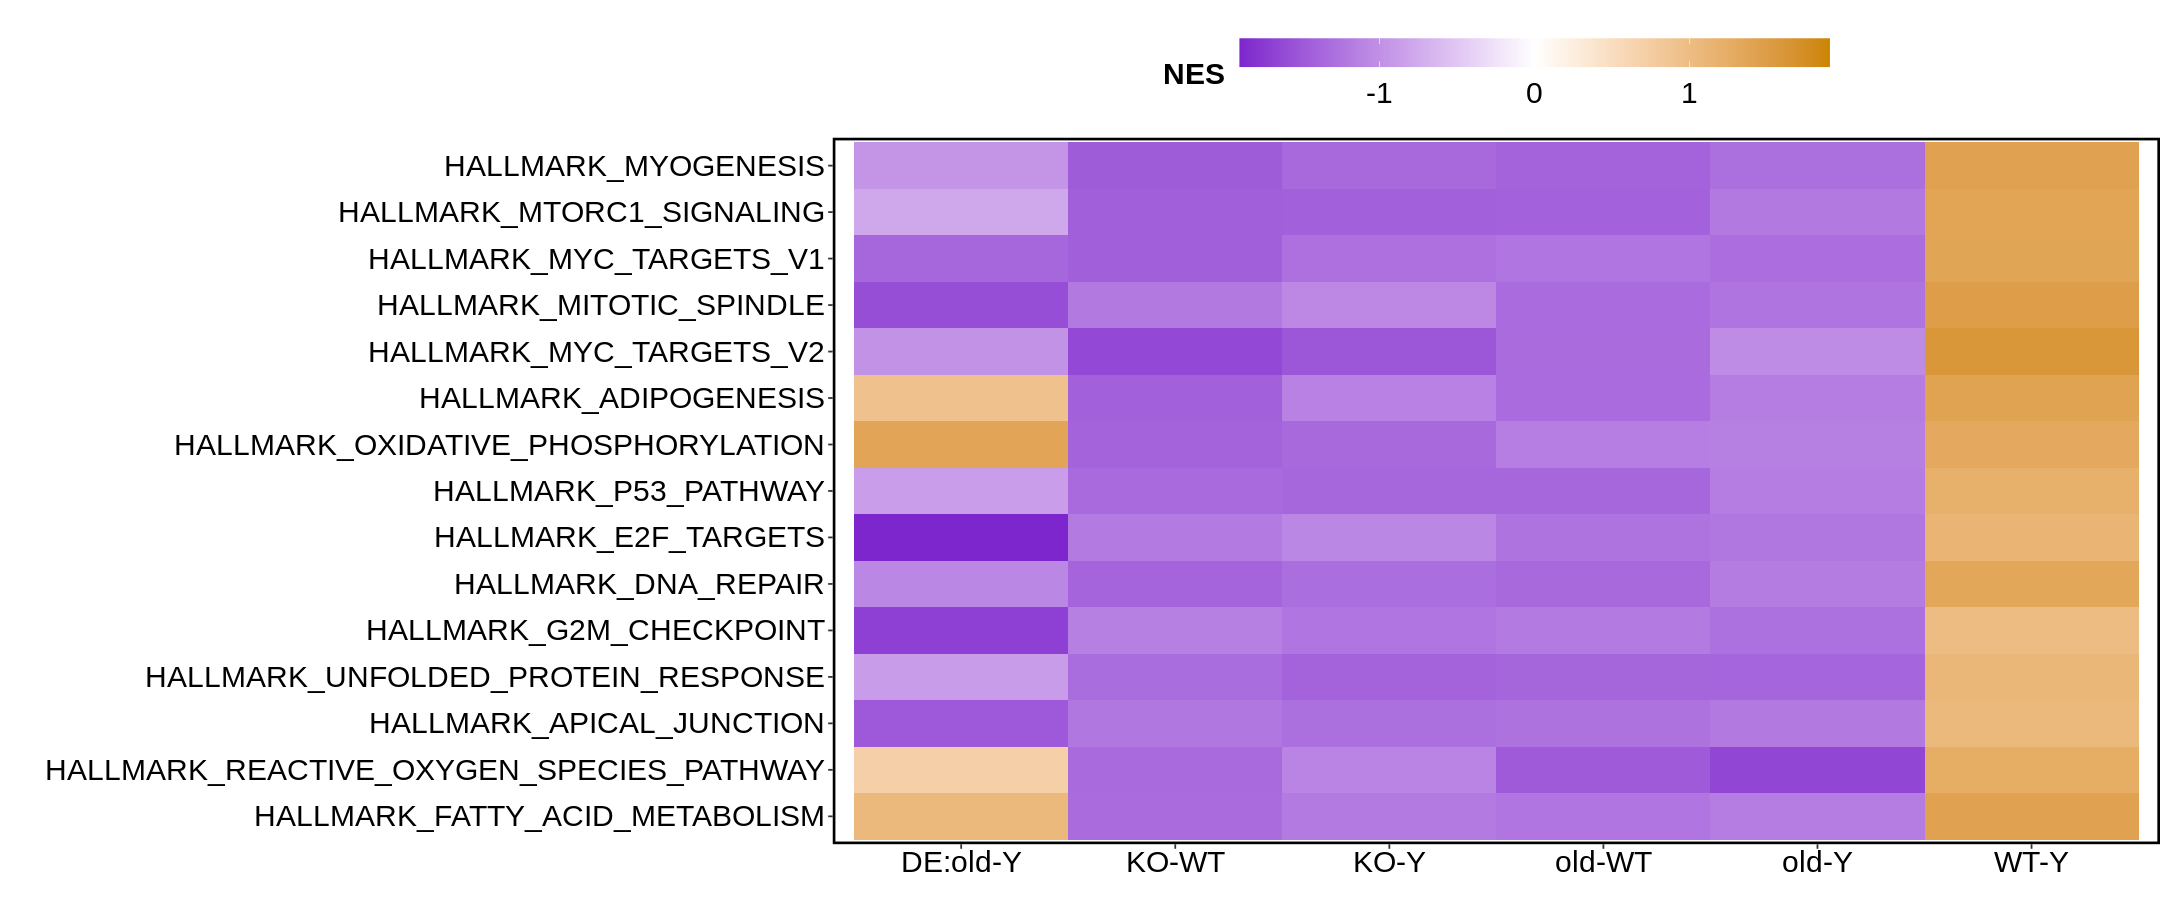

In [53]:
fontsize=18
limit <- max(abs(submelt$NES))
options(repr.plot.width = 18, repr.plot.height = nrow(submelt)/3/4)
ggplot(data=submelt, aes(x=type, y=pathway, fill=NES)) + 
    geom_tile()+
    theme(
        axis.text.y = element_text(size = fontsize, colour='black'),
        axis.text.x = element_text(size = fontsize, colour='black'),
        panel.background = element_rect(fill='white', colour='black', size=1.5, linetype='solid'),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.title=element_text(size=fontsize, face = "bold"),
        legend.text=element_text(size=fontsize),
        legend.position="top", 
        legend.key.width = unit(2.5, "cm"),
        plot.margin = unit(c(0., 0., 0., 0.5), "cm")) +
    scale_fill_gradient2(
                        high="orange3", low="purple3", mid='white', 
                        limits=c(-limit, limit), 
                        midpoint=0)+
    labs(x="", y = "", title="")

# RLE normalization

In [59]:
df <- read.csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/pseudoBulk_counts.csv', row.names=1)

In [39]:
source('utils/RLE_norm.R')

In [40]:
#Perform sample normalzation 
rle_df <- log2(RLE_normalization(df) + 1)

write.csv(rle_df, '/tank/projects/kriukov_chromatin/RNA/GSE129788/pseudoBulk_logRLE.csv')

In [68]:
library(edgeR)
library(ggplot2)
suppressMessages(library(DESeq2))

In [61]:
data <- df
genotype <- factor(c(rep("old",8), rep("young", 8) ))
meta <- data.frame(genotype, row.names = colnames(data))

In [64]:
# Create DESeq2Dataset object:
dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~1)

#Perform normalization and filter genes with low expression (delete gene if there is less than 3 samples with
#less than 5 counts):
dds <- estimateSizeFactors(dds)
idx <- rowSums(counts(dds, normalized=TRUE) >= 10 ) >= 8
dds <- dds[idx,]

In [66]:
# Perform rlog-transformation:
rld <- rlog(dds, blind=TRUE)

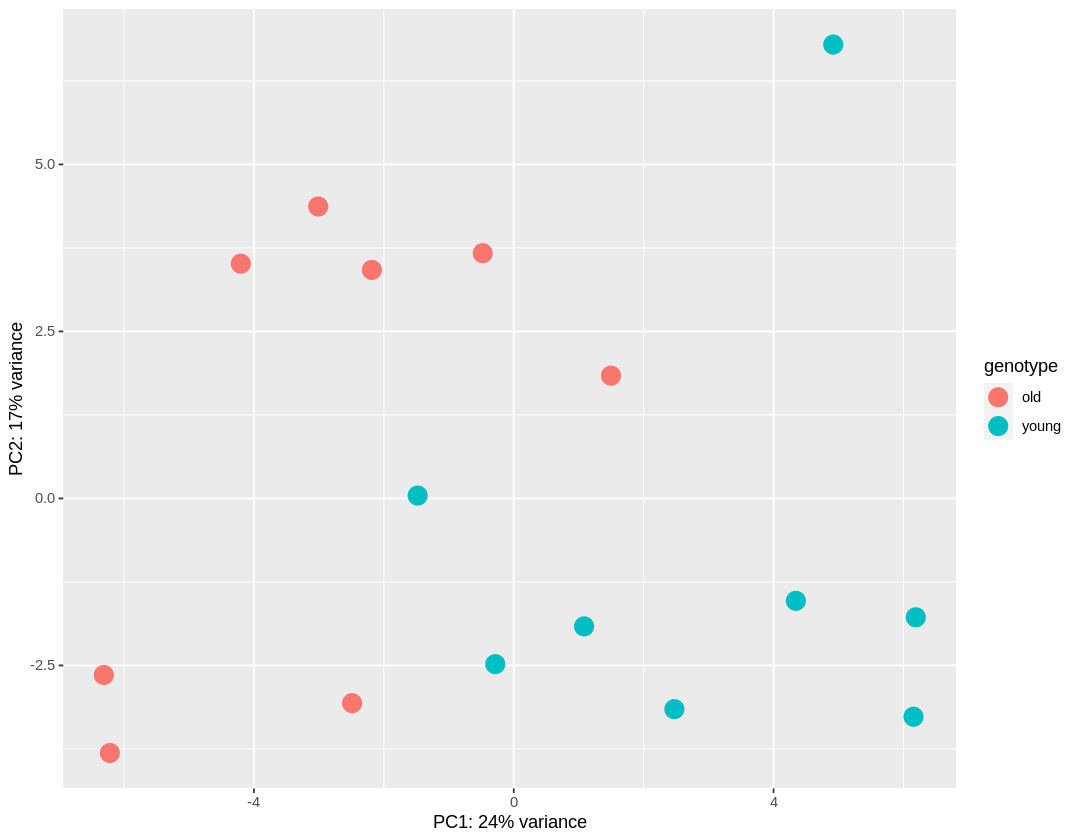

In [69]:
options(repr.plot.width=9, repr.plot.height=7)
pcaData <- plotPCA(rld,
                intgroup=c("genotype"),
                returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=genotype)) +
geom_point(size=5) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance"))
ggsave('PCA_plot.png', height = 9, width = 11.5)

In [71]:
#DE analysis
dds_factors <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ genotype)

In [73]:
#Filter genes with low expression:
dds_factors <- estimateSizeFactors(dds_factors)
idx <- rowSums(counts(dds_factors, normalized=TRUE) >= 10 ) >= 8
dds_factors <- dds_factors[idx,]
dds_factors <- DESeq(dds_factors)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [82]:
contrast <- c("genotype", 'old', 'young')
#Perform statistical analysis:
res_unshrunken <- results(dds_factors, contrast=contrast, alpha = 0.05)
#Perform lfc-shrinkage:
res <- lfcShrink(dds=dds_factors, contrast=contrast, res=res_unshrunken, type='normal')

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [86]:
dif <- as.data.frame(res)

In [92]:
dif$ES <- -log10(dif$pvalue) * dif$log2FoldChange
colnames(dif) <- c('mean', 'FC', 'SE', 'stat', 'pval', 'padj', 'ES')

In [103]:
write.csv(dif, 'subdata/DE_results_old::young.csv')